In [198]:
from field_of_view import FieldOfView
from clusters import ClusterParam, Cluster
from plot_helpers import moving_average

import numpy as np
from matplotlib import pyplot as plt

In [199]:
nm_per_pixel = 21.34
time_per_frame = 0.1
Tau_D_GluA1 = 150.32
Tau_D_GluA2 = 97
background_threshold = 200
homer_path = '../Examples/A1_aHomer_corrected.csv'
life_act_path = '../Examples/A1_Composite.tif'
deepd3_path = 'DeepD3_32F.h5'
deepd3_pred_tresh = 0.2
points_data = [['GluA1', r'../Examples/A1_GluA1_corrected.csv', 'white', time_per_frame, Tau_D_GluA1],
               ['GluA2', r'../Examples/A1_GluA2_corrected.csv', 'cyan', time_per_frame, Tau_D_GluA2]]
# Params = [ClusterParam(35, 10, 500, 50 , 'GluA2')]
Params = []


In [200]:
FOV = FieldOfView(homer_centers=homer_path, 
                  life_act=life_act_path, 
                  nm_per_pixel=nm_per_pixel,
                  points=points_data, 
                  Params=Params, 
                  threshold=background_threshold,
                  deepd3_model_path=deepd3_path,
                  deepd3_pred_thresh=deepd3_pred_tresh,
                  to_plot=False,
                  filter_spines=False)

Loading Life Act...
Setting up Thresholding...
1/1 [==============================] - 0s 364ms/step
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Loading Homer Centers...
Loading GluA1...
Loading GluA2...
Assigning Points to Spines...


clusters.py (223): Mean of empty slice.
_methods.py (184): invalid value encountered in divide


In [11]:
GluA1 = FOV.Points[0]
GluA2 = FOV.Points[1]
LifeAct = FOV.life_act

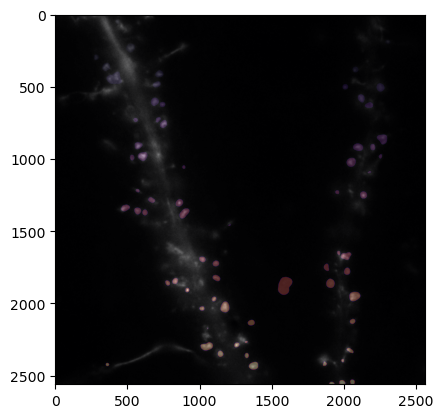

In [201]:
plt.figure()
plt.imshow(LifeAct, cmap='gray')

plt.imshow(FOV.spinemap, cmap='magma', alpha=0.3)
# plt.scatter(GluA1[:, 0], GluA1[:, 1], s=0.05, c='white')

In [410]:
from points import SubPoints
from scipy.spatial import KDTree
from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans

def points_in_area(points, xlim, ylim):
    x_mask = (points[:, 0] >= xlim[0]) & (points[:, 0] <= xlim[1])
    y_mask = (points[:, 1] >= ylim[1]) & (points[:, 1] <= ylim[0])
    indices = np.where(x_mask & y_mask)[0]
    return Cluster(points, indices, label=points.label)

def filter_by_nth_neighbor_distance(points, n, max_distance):
    kdtree = KDTree(points)
    distances = np.array(kdtree.query(points, k=n, workers=-1)[0][:, -1])
    indices = np.where(distances < max_distance)
    return Cluster(points, indices, label=points.label), distances[indices]

def get_clusters_kmeans(points, k_max=10, to_plot=False):
    # Range of k values
    k_values = np.array(range(1, k_max+1))
    sse = []

    # Calculating SSE for each k
    for k in k_values:
        centroids, distortion = kmeans(points, k, seed=0)
        sse.append(distortion)

    elbow = find_elbow(k_values, sse)
    if elbow == -1:
        return get_clusters_kmeans(points, k_max*2, to_plot)
    
    differences = []
    for i in range(len(sse) - 1):
        differences.append(sse[i+1] - sse[i])
    differences = np.array(differences)
    
    if to_plot:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(k_values, sse, 'bx-')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.axvline(elbow, linestyle='--', label=f"Optimal k = {elbow}")
        plt.title("Elbow Method For Optimal k")

        plt.subplot(1, 2, 2)
        plt.plot(k_values[:-1], differences, 'go-')
        plt.xlabel('k')
        plt.ylabel('Different Between Points')
        
        plt.tight_layout()
        plt.show()

    centroids = kmeans(points, elbow, seed=0)[0]
    cluster_indices = vq(points, centroids)[0]
    clusters = []
    for i in range(elbow):
        clusters.append(Cluster(points, np.where(cluster_indices == i), label=f"{points.label} Cluster {i}"))
    return centroids, clusters
    
    
def find_elbow(k_values, sse, min_percent=0.15, change_per_k=0.025):
    max_val = max(sse)
    scaled_sse = [err/max_val for err in sse]
    for i in range(len(sse)-1):
        if scaled_sse[i] < min_percent and (scaled_sse[i] - scaled_sse[i+1]) < change_per_k:
            return k_values[i]
    # else return -1 (which will cause get_clusters_kmeans to reiterate with higher k_max)
    return -1
        


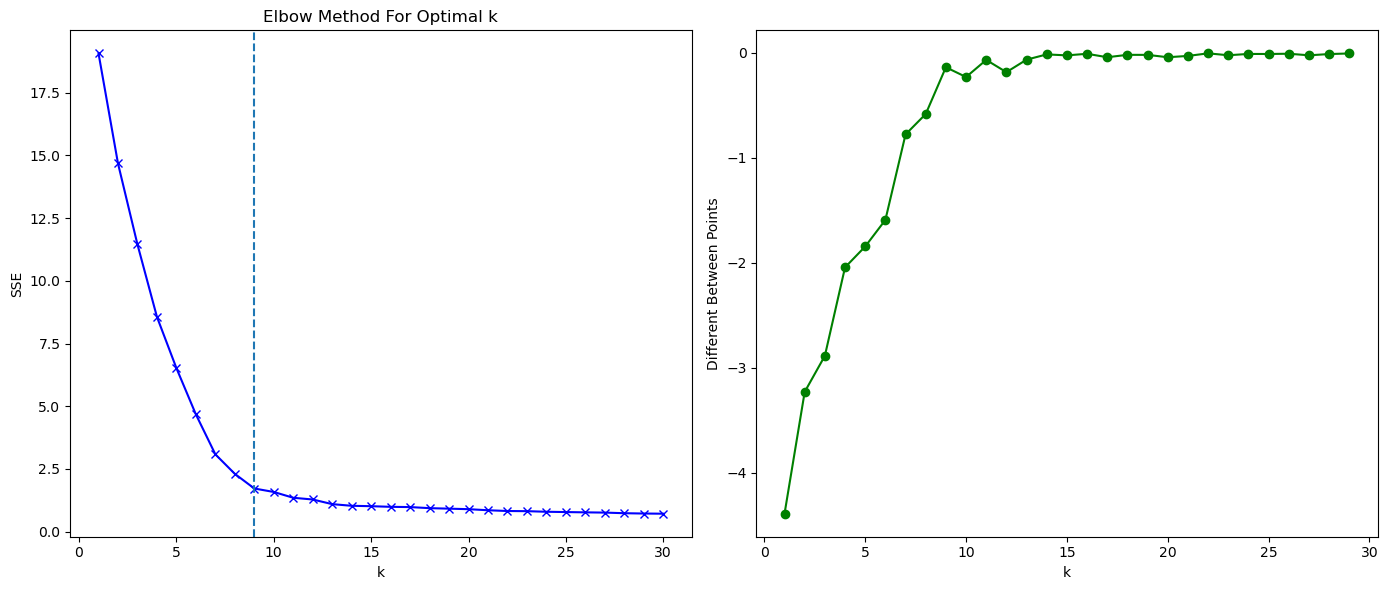

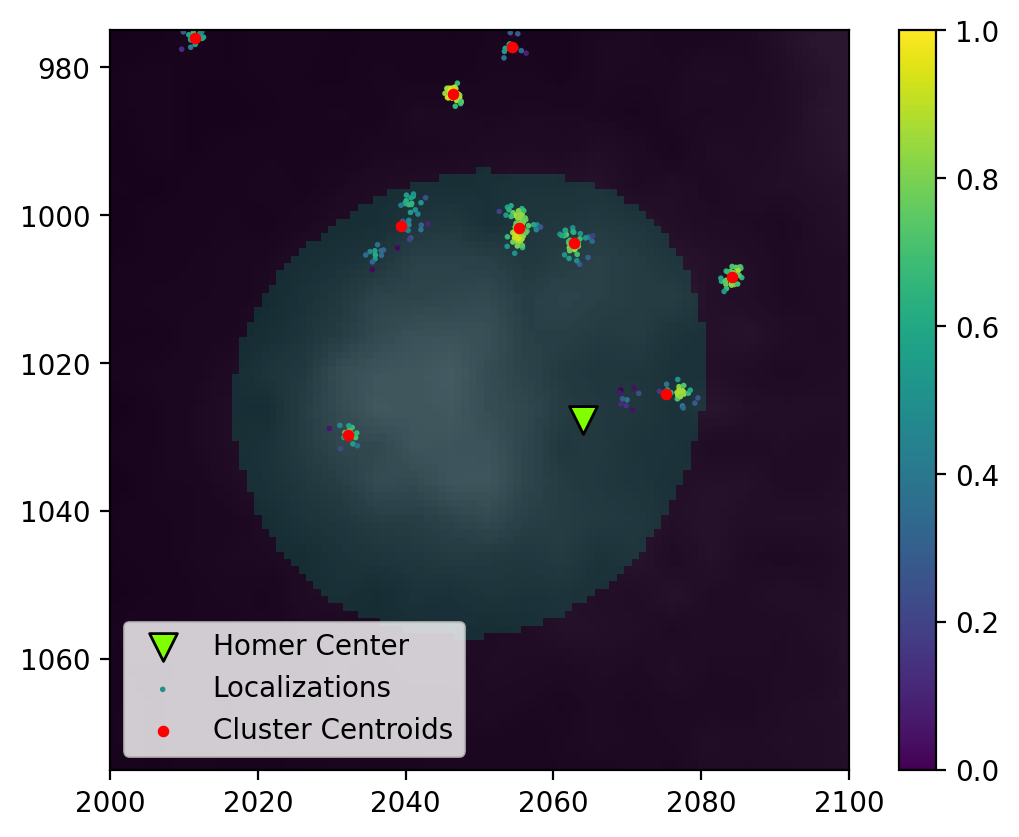

No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


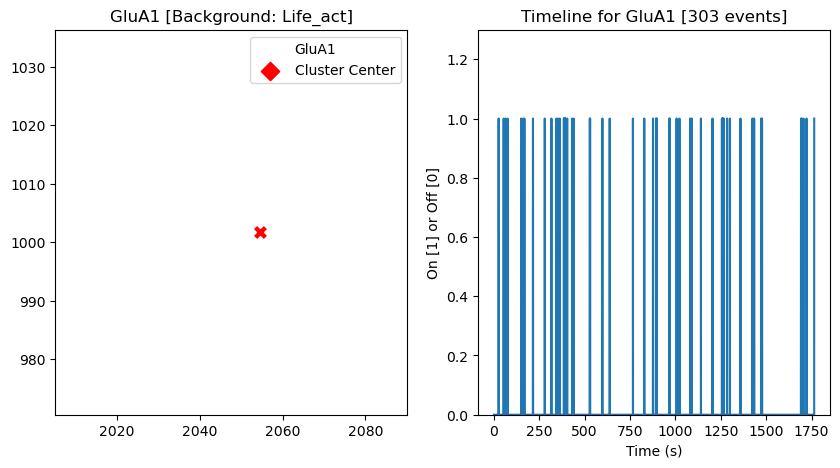

1576436841184882.5
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


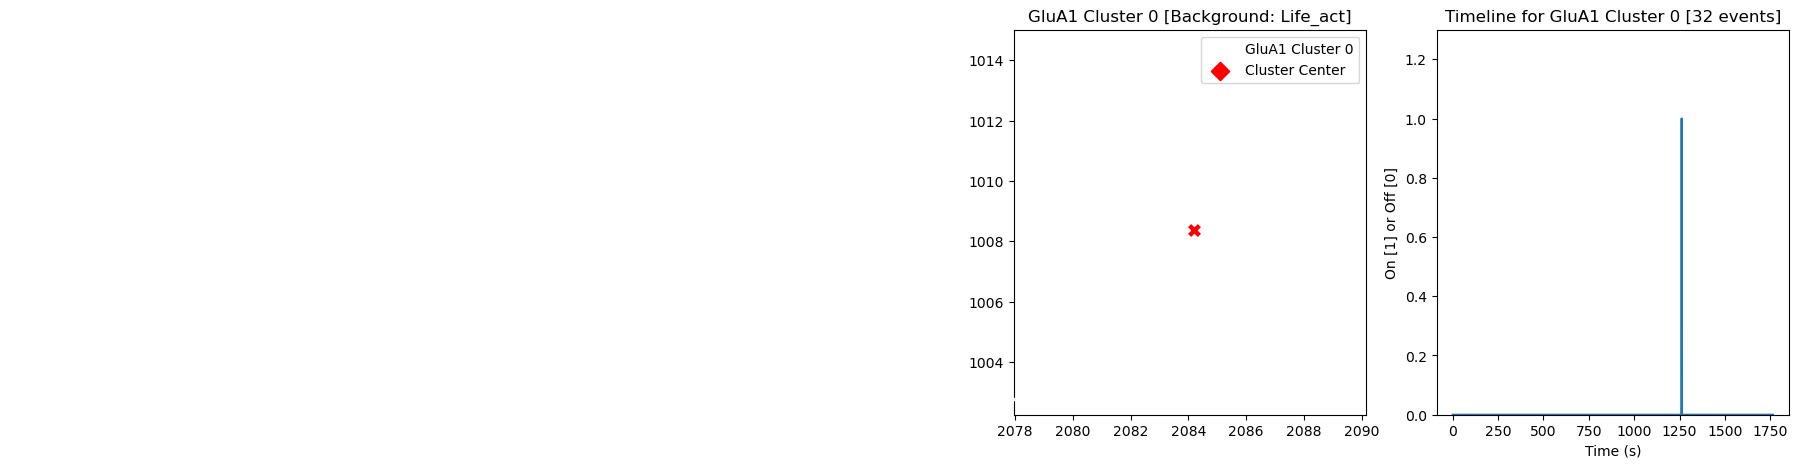

3.180081366965006
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


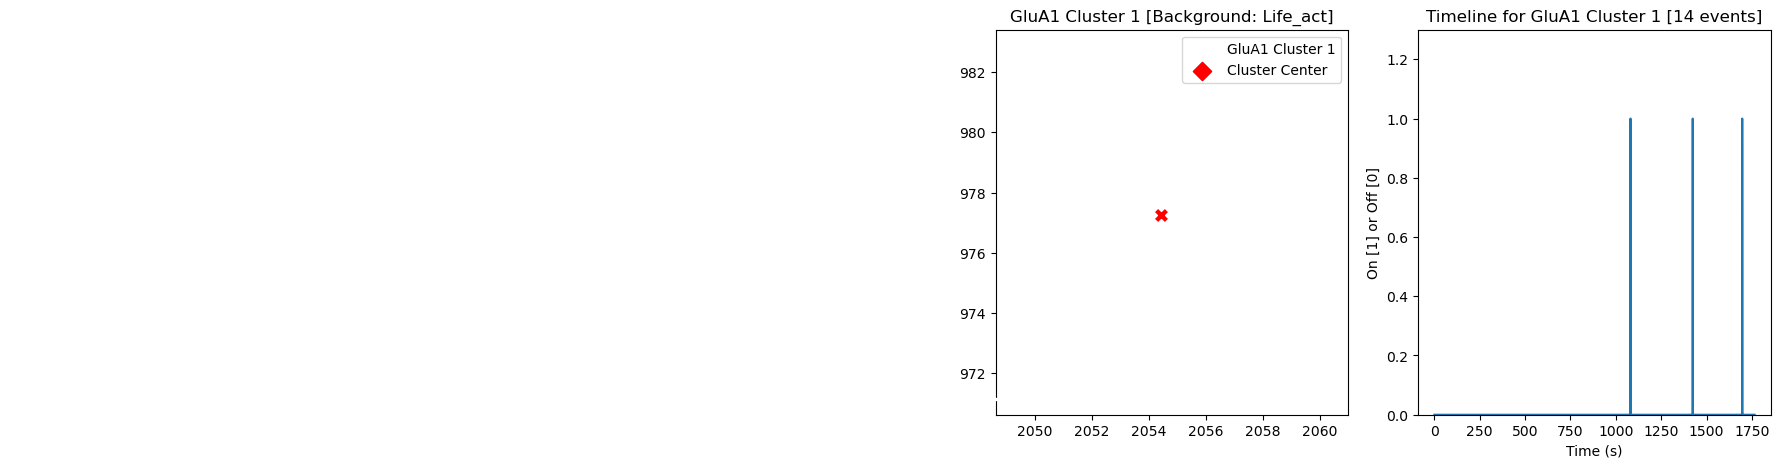

3.992706389088289
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


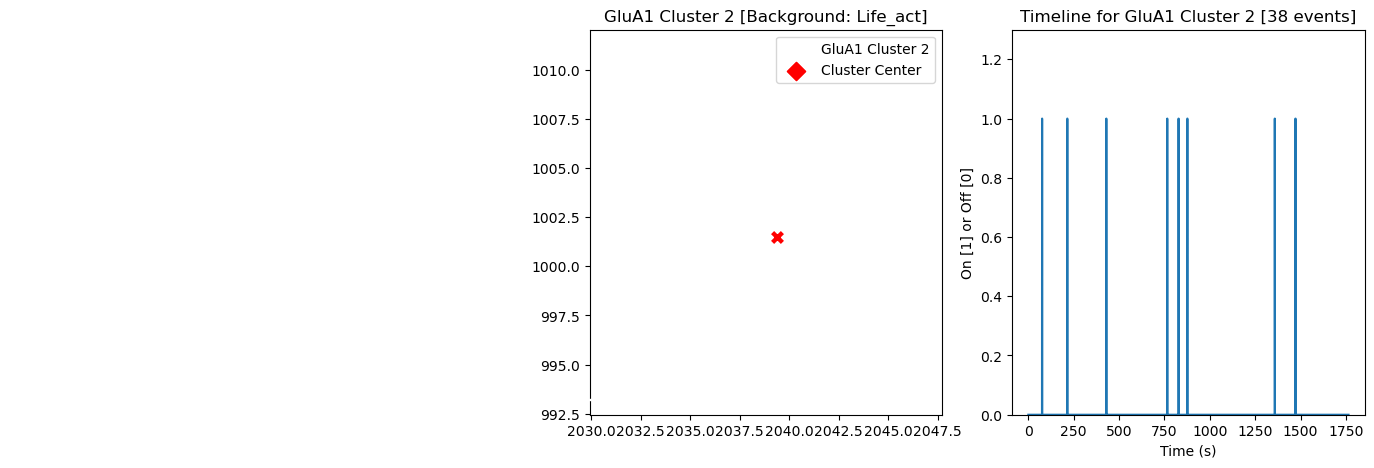

4.705342237061756
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


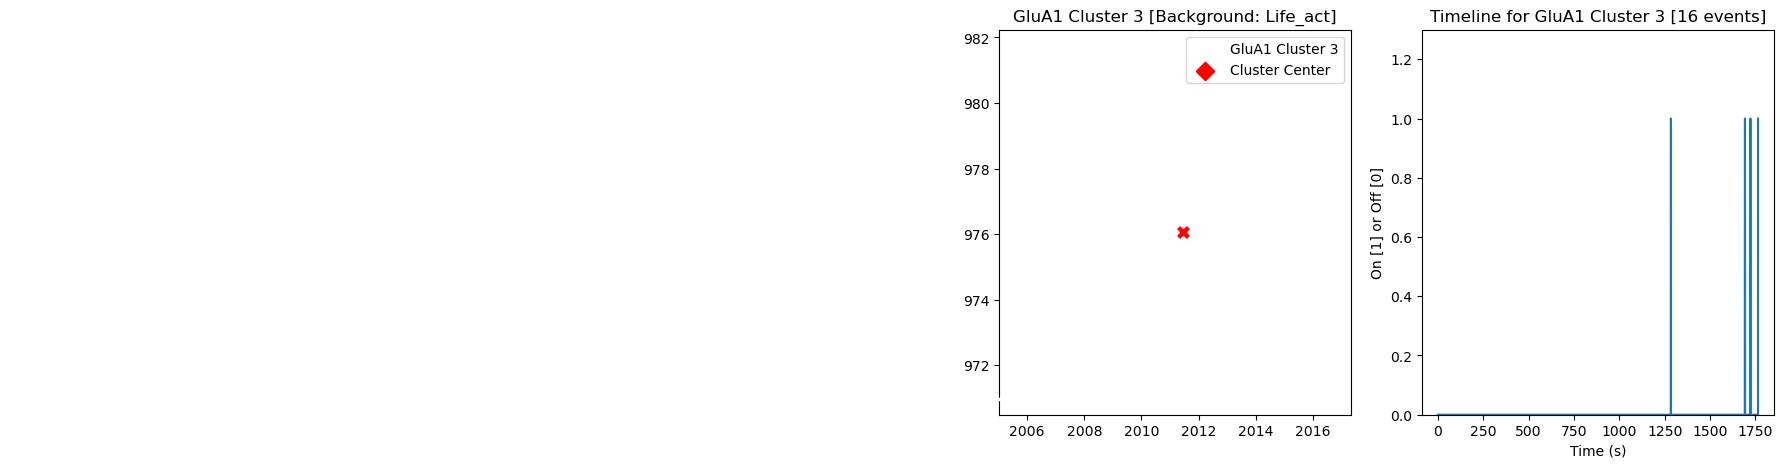

22.510482529118022
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


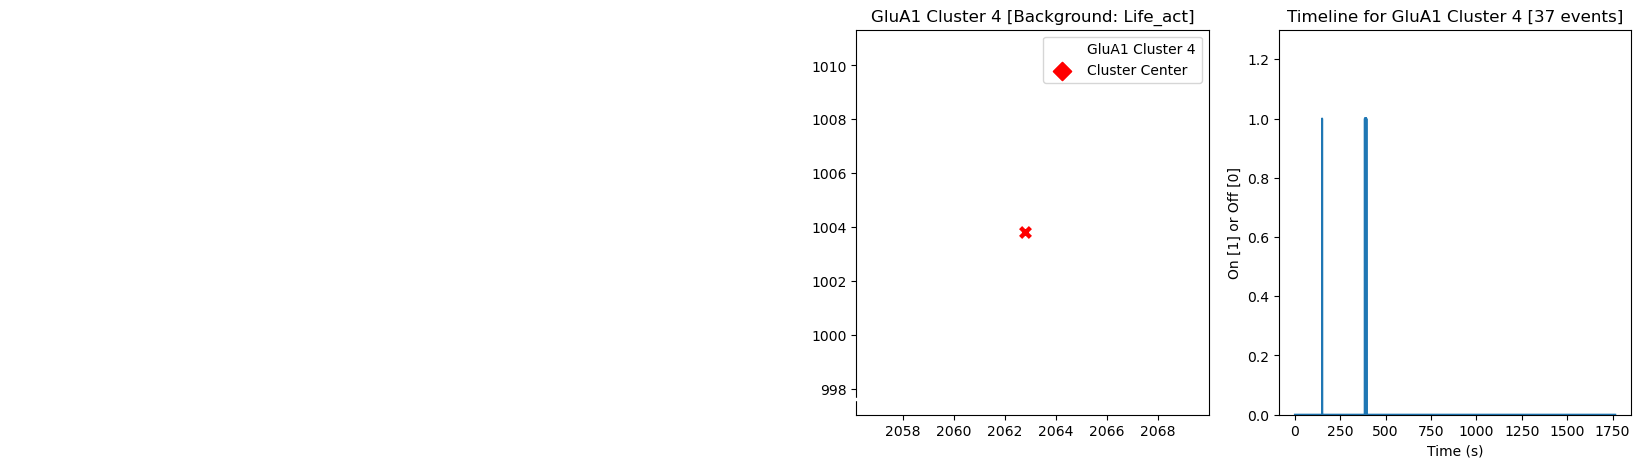

5.930491960069319
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


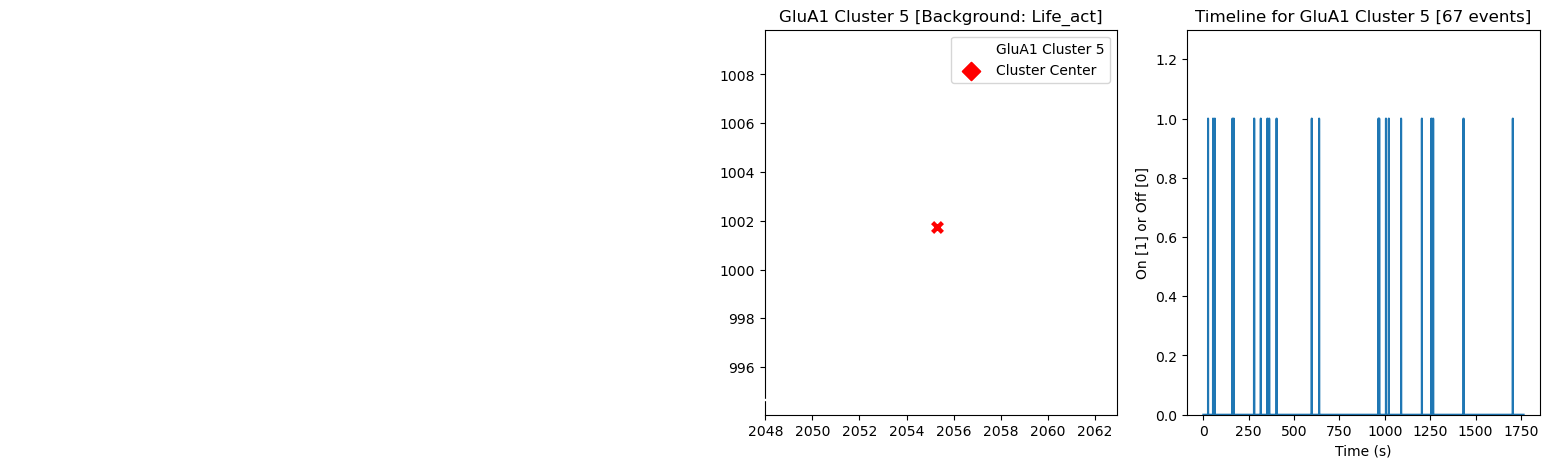

6.648731624821099
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


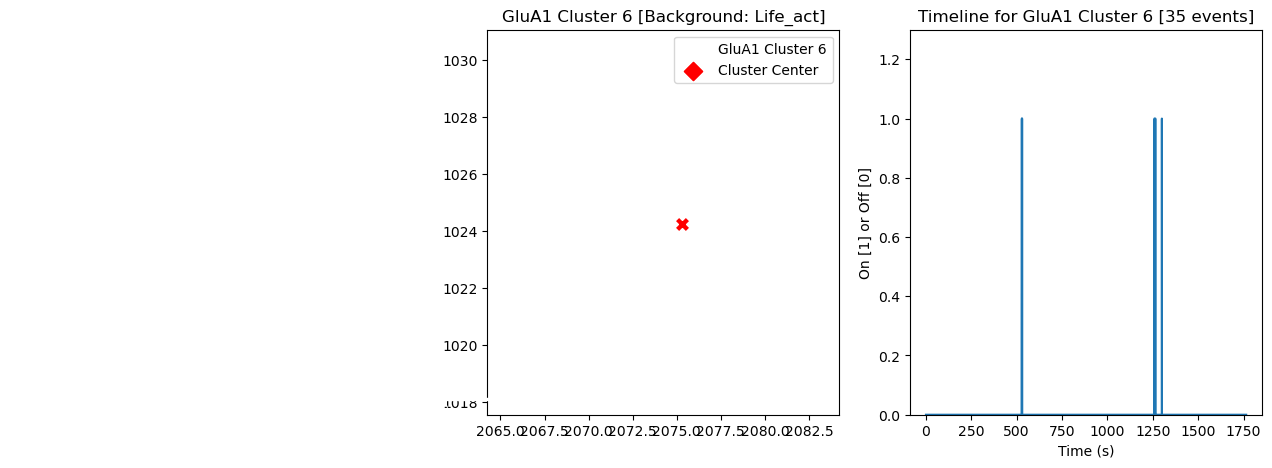

2.2576552699001646
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


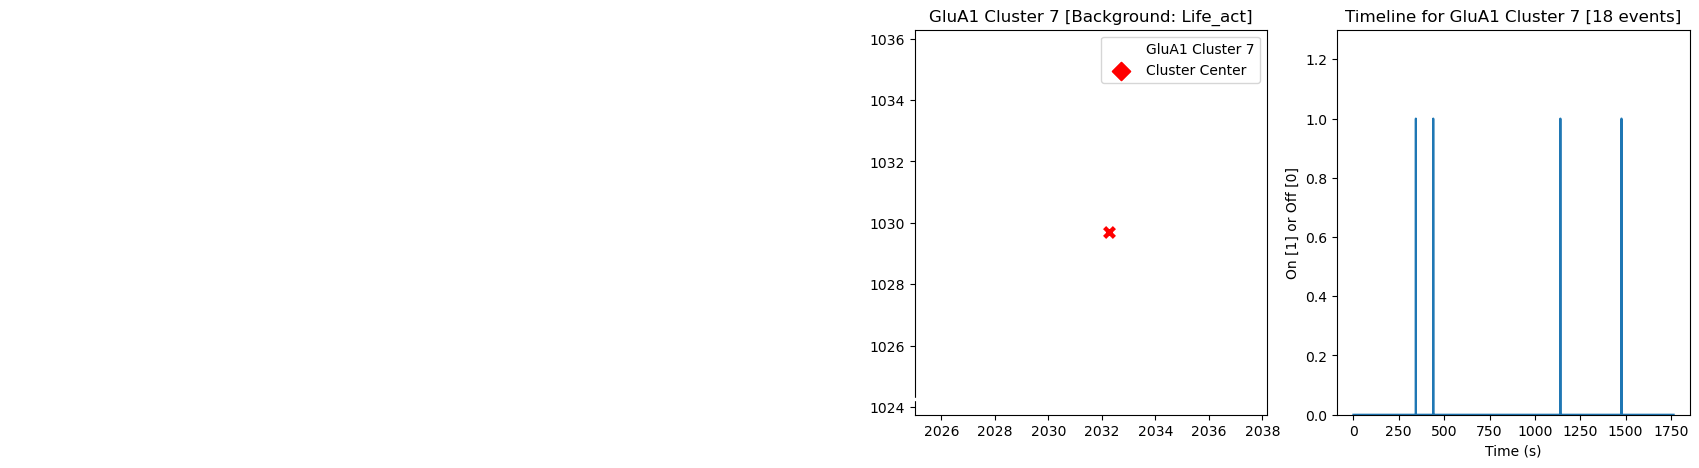

11.652713178294489
No FOV attached to cluster, cannot plot life_act
No FOV attached to cluster, cannot plot homers


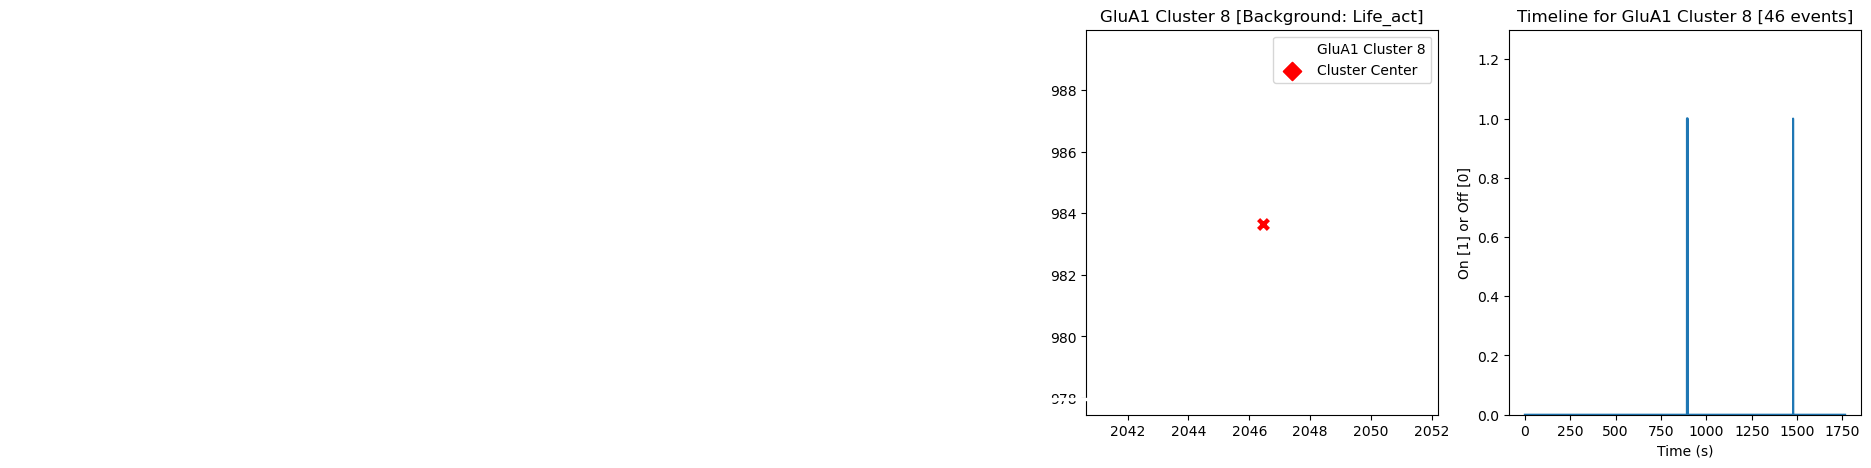

In [447]:
xlim = (2000, 2100)
ylim = (1075, 975)
n=10
k_max = 30
max_distance = 70/nm_per_pixel

# MMD Visualization
points = points_in_area(GluA1, xlim, ylim)
kdtree = KDTree(points)
distances = np.array(kdtree.query(points, k=n, workers=-1)[0][:, -1])

points, distances = filter_by_nth_neighbor_distance(points, n, max_distance)
points, distances = filter_by_nth_neighbor_distance(points, n, max_distance)
centroids, clusters = get_clusters_kmeans(points, k_max=k_max, to_plot=True)

plt.figure(dpi=200)
plt.imshow(LifeAct, cmap='gray')
plt.imshow(FOV.spinemap, alpha=0.3)
plt.xlim(*xlim)
plt.ylim(*ylim)
FOV.homer_centers.add_to_plot()
plt.scatter(points[:, 0], points[:, 1], c=distances, s=1, cmap='viridis_r', label="Localizations")
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=10, label="Cluster Centroids")
plt.colorbar()
plt.legend(loc="lower left")
plt.show()
points.plot()
for cluster in clusters:
    print(cluster.Tau_D/cluster.average_dark_time)
    cluster.plot()

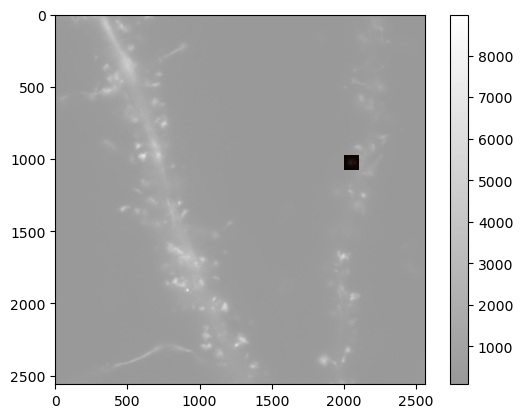

541930933.py (22): No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


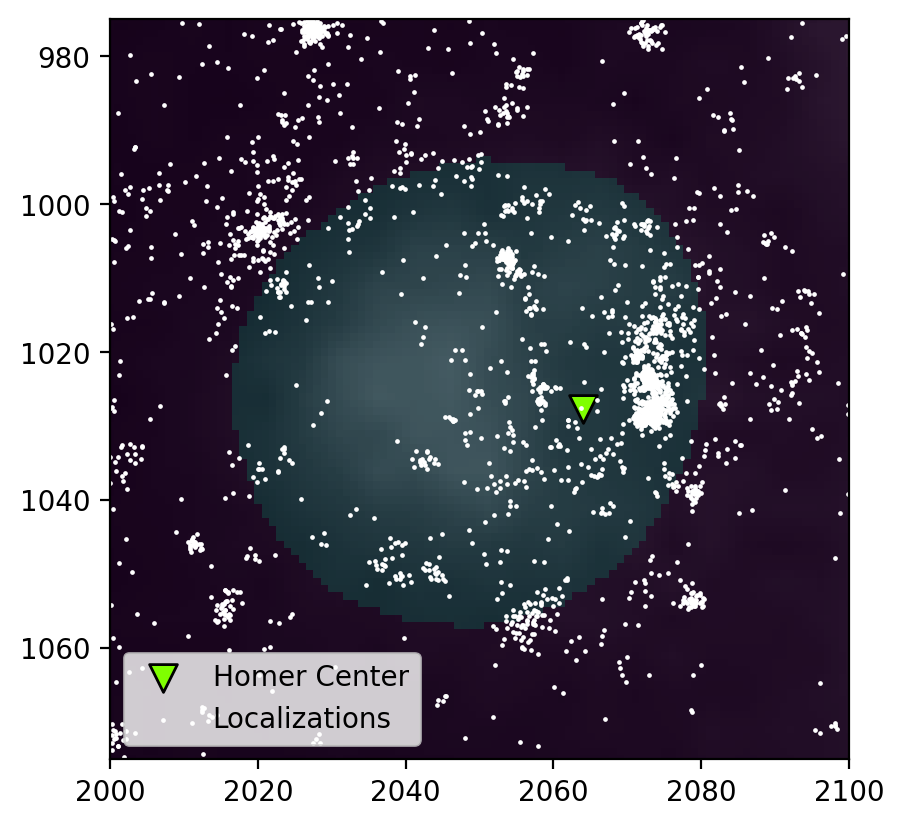

In [435]:
xlim = (2000, 2100)
ylim = (1075, 975)
points = GluA2
points = points_in_area(points, xlim, ylim)

heatmap, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=(50, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# Plot the heatmap
plt.clf() # Clear current figure
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot')
plt.imshow(LifeAct, cmap='gray', alpha=0.4)

plt.colorbar() # Add a colorbar to a plot
plt.show()

plt.figure(dpi=200)
plt.imshow(LifeAct, cmap='gray')
plt.imshow(FOV.spinemap, alpha=0.3)
plt.xlim(*xlim)
plt.ylim(*ylim)
FOV.homer_centers.add_to_plot()
plt.scatter(points[:, 0], points[:, 1], c='white', s=0.50, cmap='viridis_r', label="Localizations")
plt.legend(loc="lower left")
plt.show()